In [203]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from numpy.random import default_rng


In [204]:
from numpy.random import default_rng
rng = default_rng()

Создание объектов:
[номера вопросов, ответы на них][взял ли кредит(0 или 1)] или [номера вопросов, нули(пропустил опросник), ответы, нули][0]



In [205]:
X_rand = np.array([np.concatenate((np.array(rng.choice(30, size= 6-i, replace=True))+1,
                                   np.zeros(i,dtype = int), 
                                   np.array(rng.choice(2, size = 6-i))+1,
                                      np.zeros(i,dtype = int),
                                   np.array([np.random.randint(2) + 1 if i == 0 else 0]),
                                    np.array([np.random.randint(2) if i ==0 else 0])))
                                   for i in rng.choice(7, 500, p=[0.4,0.1,0.1, 0.1, 0.1, 0.1,0.1])])

# Предобработка данных

X_need, y_need = np.hsplit(X_rand,[13])[0], np.hsplit(X_rand,[13])[1].T
y_need = y_need[0][X_need[:,12] != 0]
X_need = X_need[X_need[:,12] != 0]


X = X_need
y = y_need


In [206]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_need, y_need, test_size=0.2, random_state=40)


In [207]:
X_train.shape, y_train.shape

((164, 13), (164,))

In [208]:
X_test.shape, y_test.shape

((41, 13), (41,))

In [209]:
X.shape, y.shape

((205, 13), (205,))

In [210]:
#y_true.shape

Моиск оптимальных гиперпараметров: max_depth, n_estimators (Можно закинуть выше - перед модификацией RandomForestClassifier)

In [214]:
# ищем лучшие max_depth, n_estimators через максимизацию accuracy
from sklearn.metrics import accuracy_score

maxsum = 0
est_opt = 0
depth_opt = 0

for i in range(1,10):
    for k in range(5,100):
        regr = RandomForestClassifier(max_depth=i, n_estimators=k, random_state=1)
        regr.fit(X_train,y_train)
        #y_predict = regr.predict_proba(X_test)
    
        #y_pred

        acc = regr.score(X_test,y_test)
    
        #print("max_depth = ", i," n_estimators = ",  "Accuracy = ", acc)
    
        if (maxsum < acc):
            maxsum = acc
            est_opt = k
            depth_opt = i
            
print('max Accuracy = ', maxsum,'opt estim number =', est_opt, 'opt depth number =', depth_opt)


max Accuracy =  0.5609756097560976 opt estim number = 7 opt depth number = 8


In [215]:
#max_depth = None
from sklearn.metrics import accuracy_score

model = RandomForestClassifier(max_depth = depth_opt, n_estimators = est_opt, random_state=1).fit(X_train,y_train)
prob = model.predict_proba(X_test)
predd = model.predict(X_test)

model.score(X_test,y_test) 

#model.estimators_

0.5609756097560976

Модифицируем RandomForestClassifier

In [216]:
#Запишем массив деревьев и их личное accuracy

model_accs=[] #list of score accuraces

for idx, tree in enumerate(model.estimators_):
    score = tree.score(X_test, y_test)
    model_accs.append([idx,score])
model_accs = np.array(model_accs)
model_accs

array([[0.        , 0.6097561 ],
       [1.        , 0.46341463],
       [2.        , 0.3902439 ],
       [3.        , 0.3902439 ],
       [4.        , 0.51219512],
       [5.        , 0.53658537],
       [6.        , 0.51219512]])

In [217]:
#сортируем 2 столбец - индексы деревьев с accuracy в порядке убывания

model_ids = np.argsort(model_accs[:, 1])[::-1]
model_ids

array([0, 5, 6, 4, 1, 3, 2])

In [220]:
# создаем массив деревьев на основе model_ids
model.estimators_ = np.array(model.estimators_)[model_ids].tolist()


In [226]:
#Теперь проверим, какое оптимальное k выбирать - посмотрим как работает дерево при n_estimators = 1, 2,...

import copy

result = []

total_models = len(model.estimators_) 

k_opt = 0
maxacc = 0

for k in range(2, total_models):
    
    model_copy = copy.deepcopy(model)
    
    model_copy.estimators_ = model.estimators_[:k]
    
    score = model_copy.score(X_test, y_test)
    result.append([k,score])
    
    if (maxacc < score):
        maxacc = score
        k_opt = k
    
result
#print(k_opt)

[[2, 0.5365853658536586],
 [3, 0.4878048780487805],
 [4, 0.5609756097560976],
 [5, 0.5365853658536586],
 [6, 0.5365853658536586]]

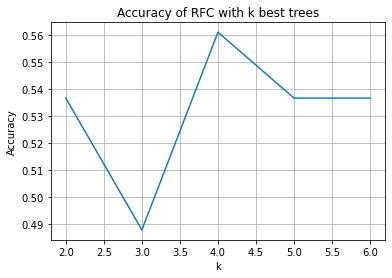

In [227]:
# Ищем оптимальное число деревьев k с максимальной accuracy, на которых будет работать алгоритм
# Строим график для наглядности

import matplotlib.pyplot as plt

x_grid = []
y_grid = []

for m in range(len(result)):
    x_grid.append(result[m][0])
    y_grid.append(result[m][1])

plt.plot(x_grid, y_grid)
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Accuracy of RFC with k best trees')
plt.grid(True)
plt.show()

In [228]:
small_model = copy.deepcopy(model)
    
small_model.estimators_ = model.estimators_[:k_opt]

small_model.score(X_test, y_test)

# Уменьшили число деревьев, увеличили число accuracy 

0.5609756097560976